In [1]:
import pandas as pd
import numpy as np
import json
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn


from matplotlib import pyplot as plt
from PIL import Image



import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torchinfo import summary

import helper
import pkbar
from collections import OrderedDict
import copy


# Part A

In [2]:
with open('imagenet_class_index.json') as json_file:
    data = json.load(json_file)
# data
imagenet_labels_names = {}
for key,item in data.items():
    imagenet_labels_names[int(key)] = item[1]

Επιλεγμένας κατηγορίες με 5 εικόνες από το internet η καθεμία:
- '113': ['n01944390', 'snail']    
- '150': ['n02077923', 'sea_lion']    
- '401': ['n02672831', 'accordion']    
- '621': ['n03649909', 'lawn_mower']    
- '954': ['n07753592', 'banana']    


In [42]:
my_labels_dict = {
    113 : 4,
    150 : 3,
    401 : 0,
    621 : 2,
    954 : 1
}

label_name = {
    0 : "accordion",
    1 : "banana",
    2 : "lawn_mower",
    3 : "sea_lion",
    4 : "snail"
}

In [43]:
# summary(resnet50,(16,3,224,224))

### Importing pretrained models

In [44]:
resnet50 = models.resnet50(pretrained=True)
alexnet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
squeezenet1_0 = models.squeezenet1_0(pretrained=True)
googlenet = models.googlenet(pretrained=True)


model_names = {
    "resnet50" : resnet50,
    "alexnet" : alexnet,
    "vgg16" : vgg16,
    "squeezenet1_0" : squeezenet1_0,
    "googlenet" : googlenet 
}

### Importing custom dataset

In [7]:
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
                                ])
data_dir = './part_A/my_data'
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1])


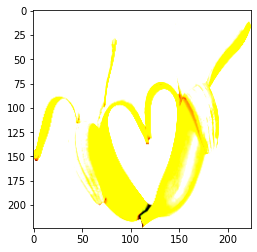

In [8]:
# print an image to visualize the data
images, labels = next(iter(dataloader))
plt.imshow(images[0].permute(1, 2, 0))
print(labels)

### Getting predictions from each model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

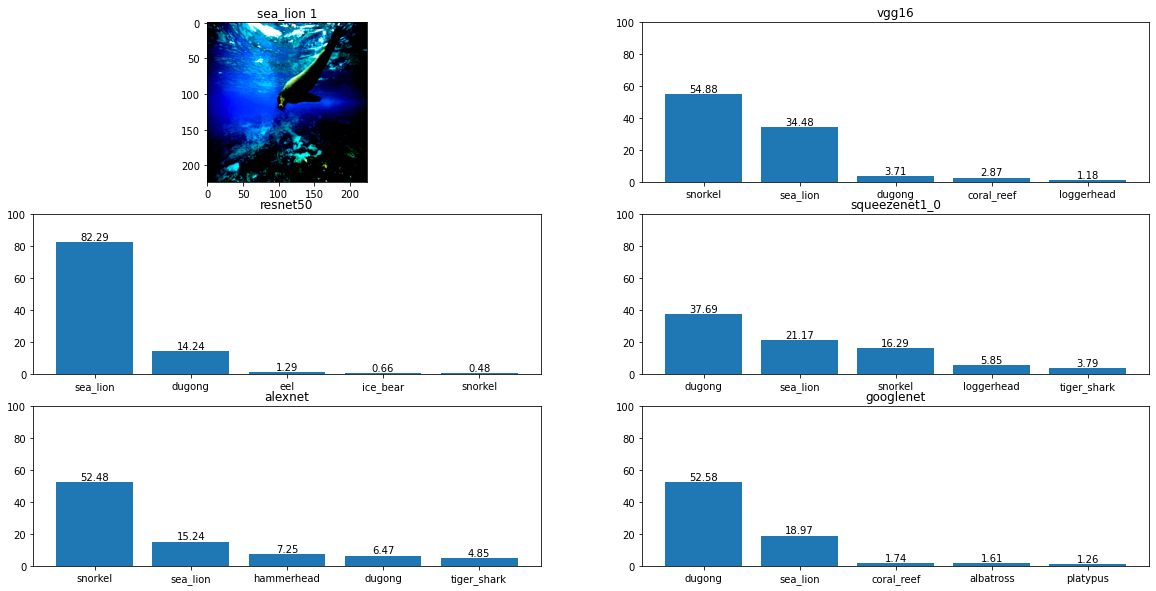

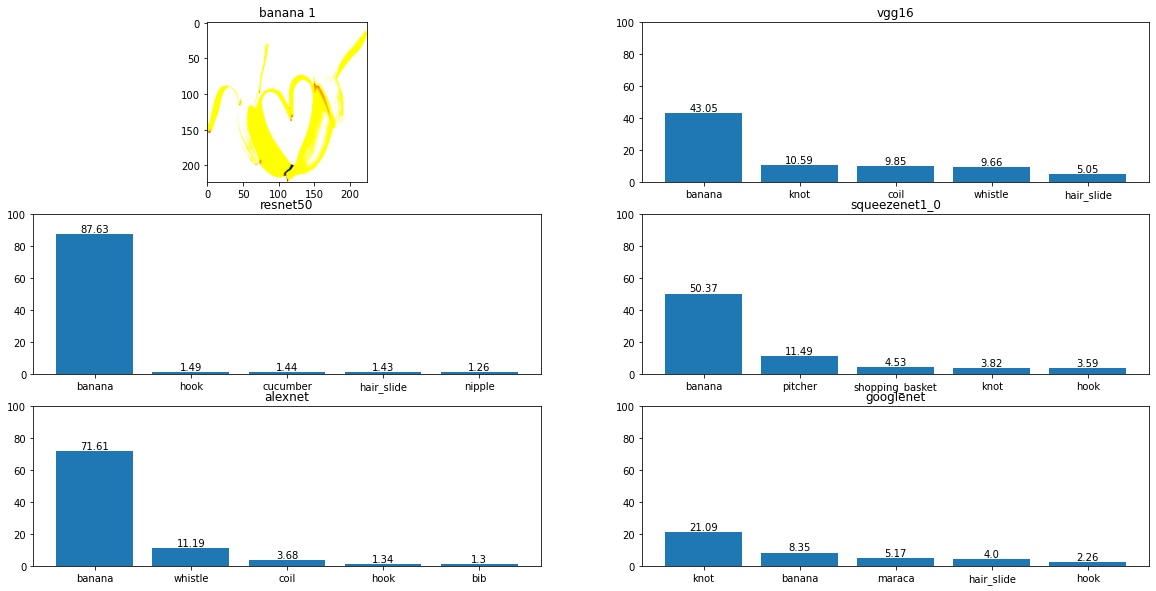

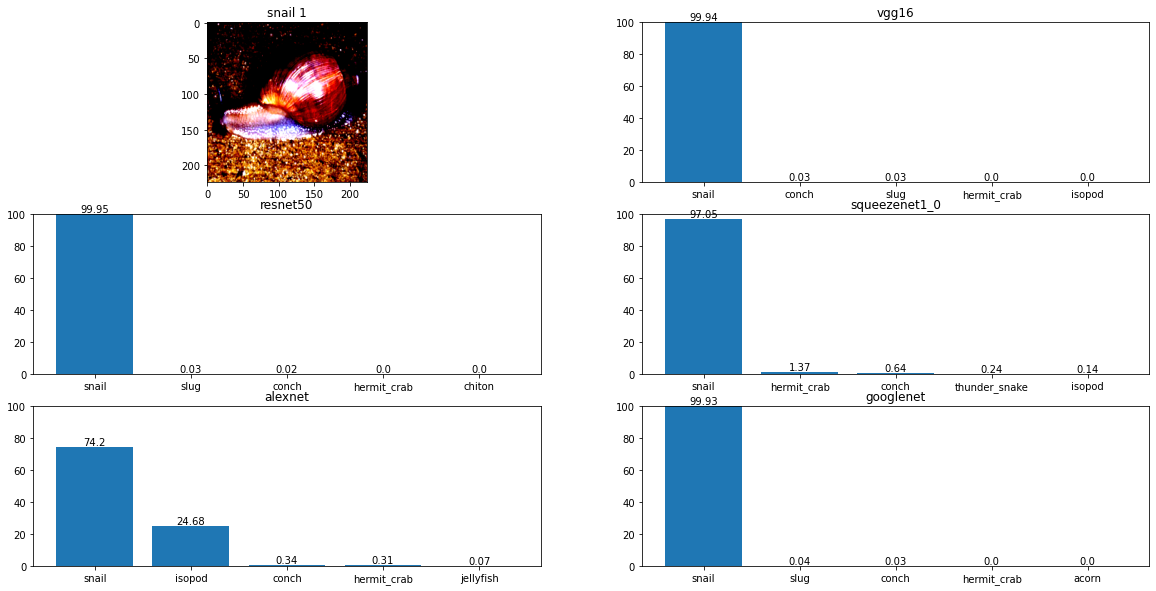

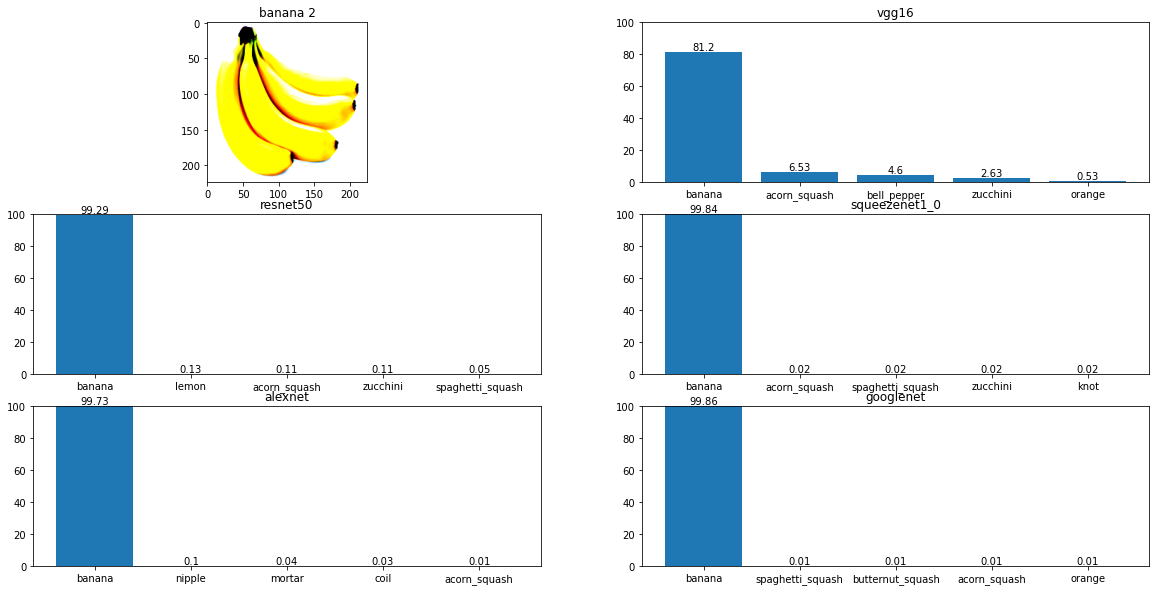

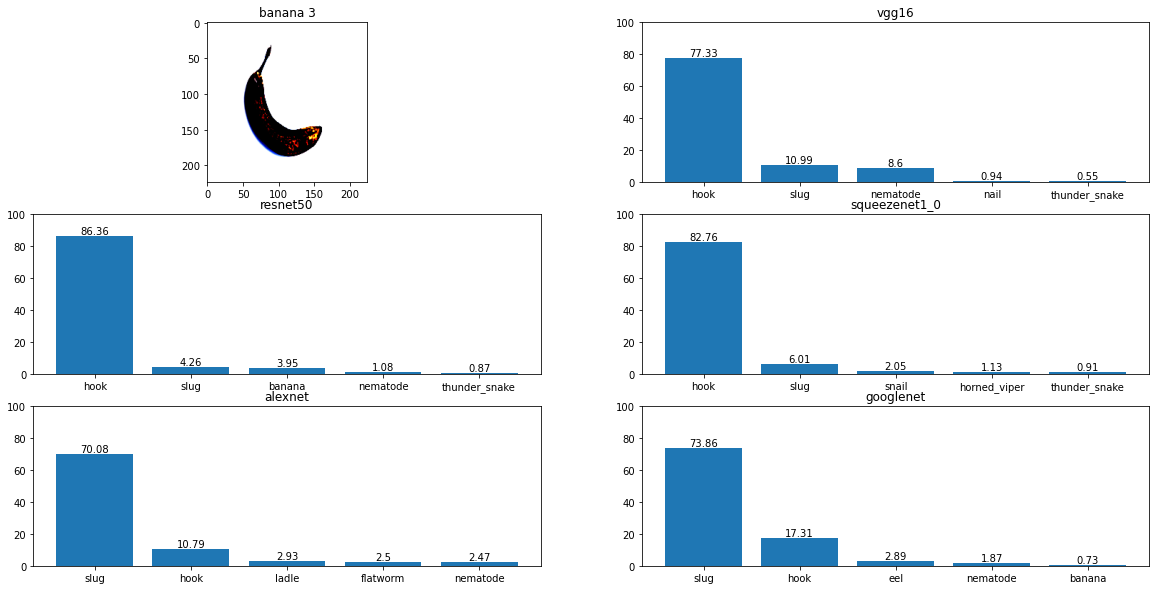

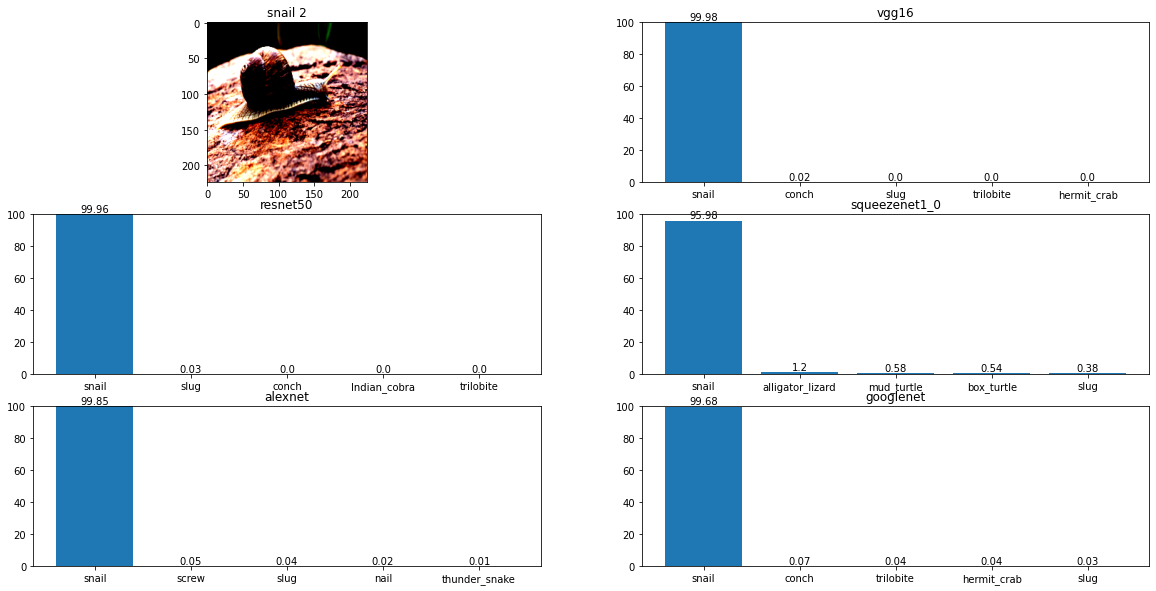

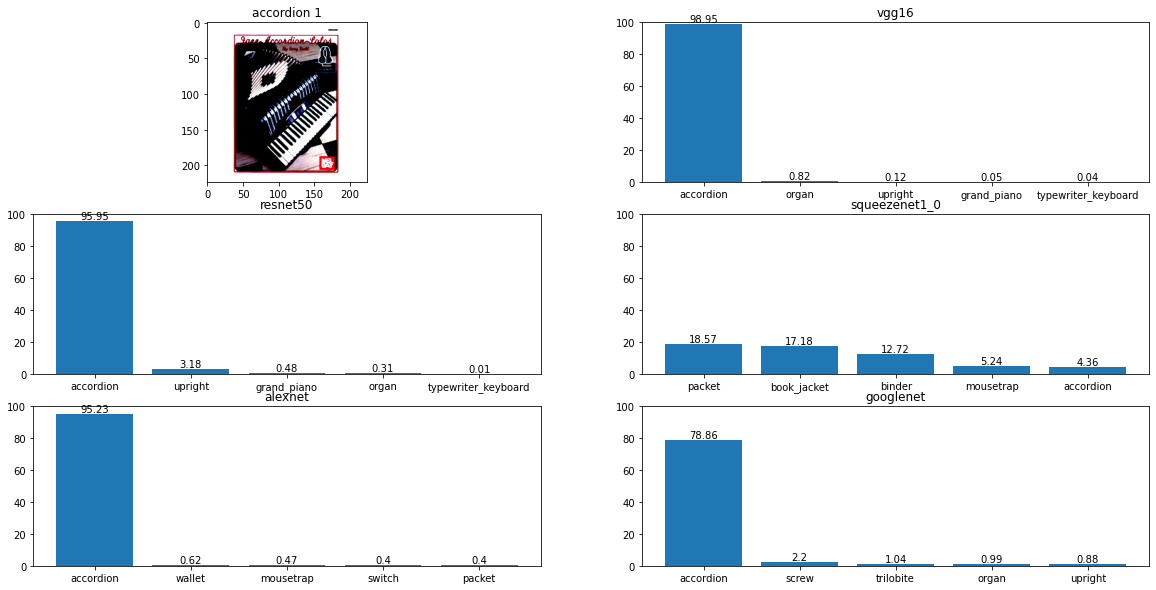

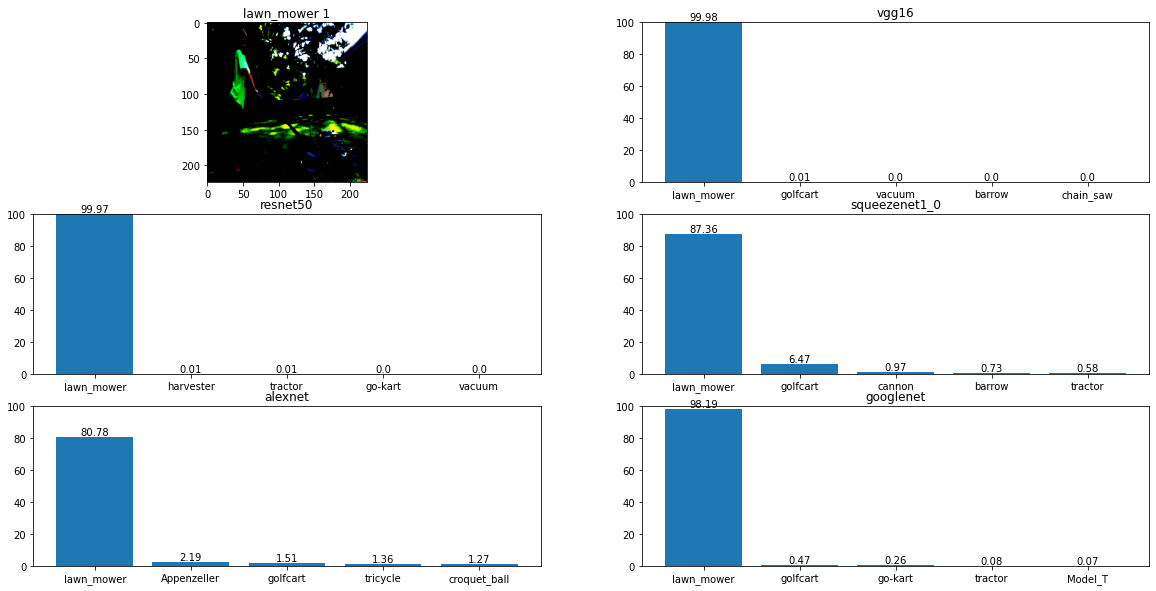

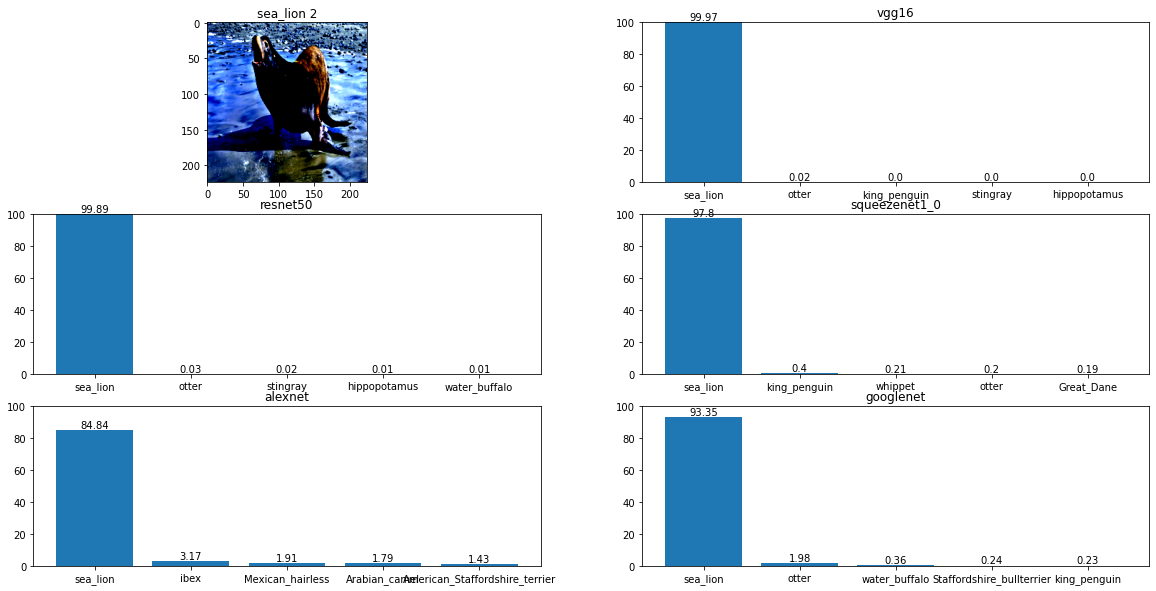

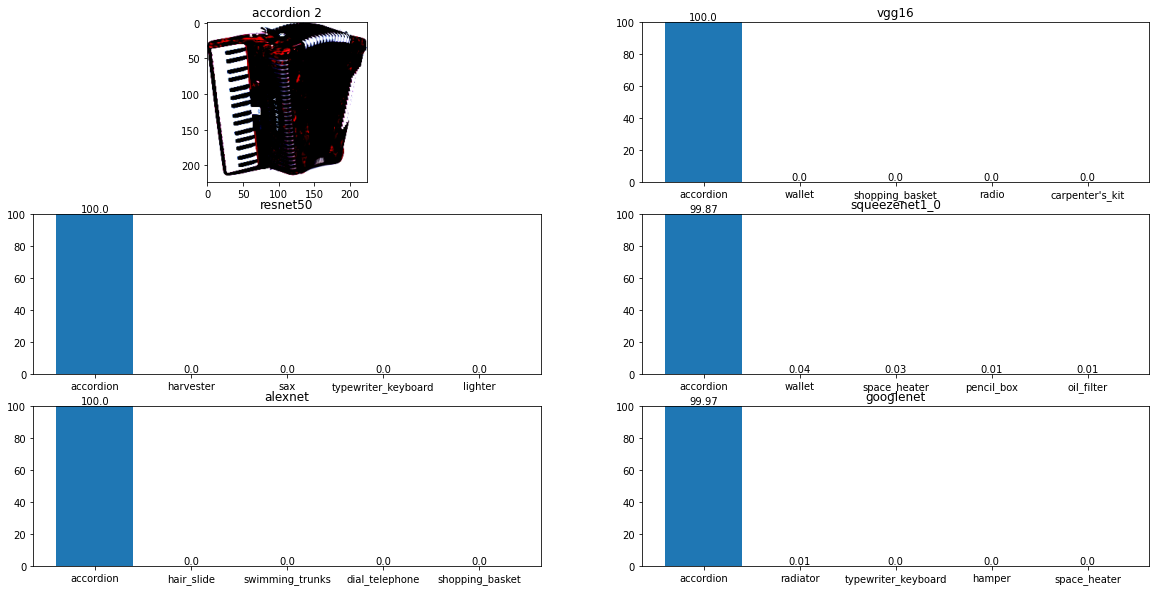

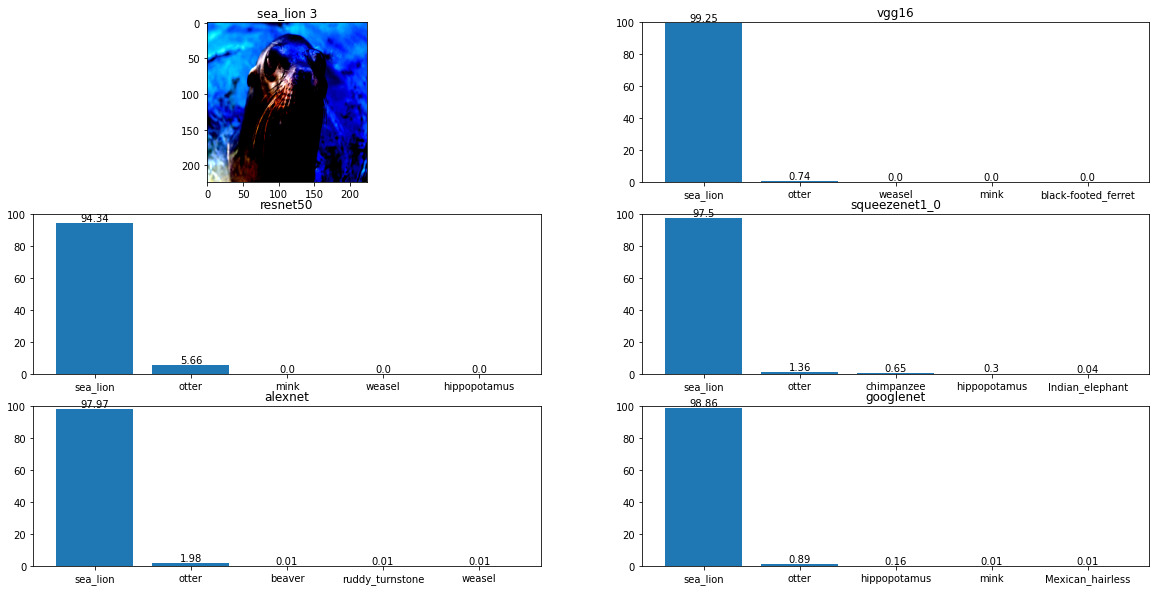

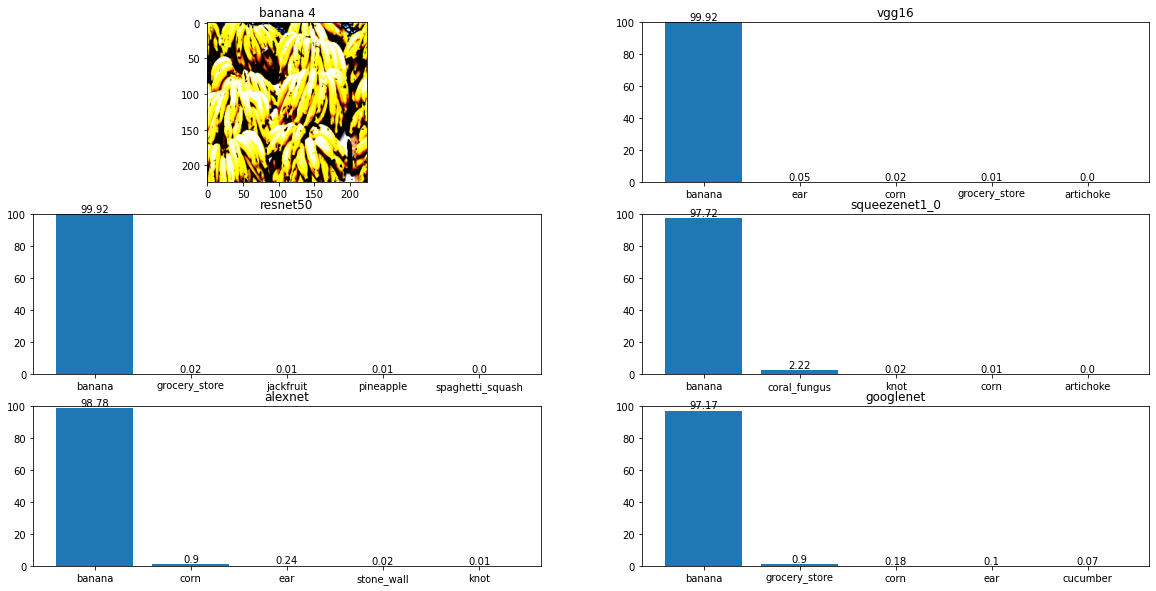

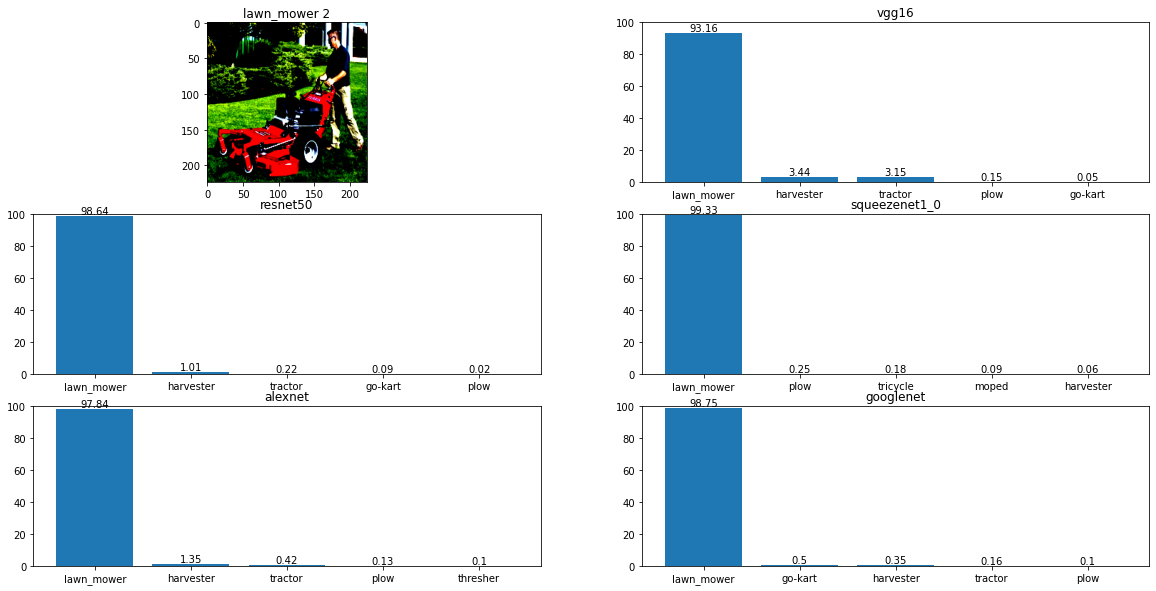

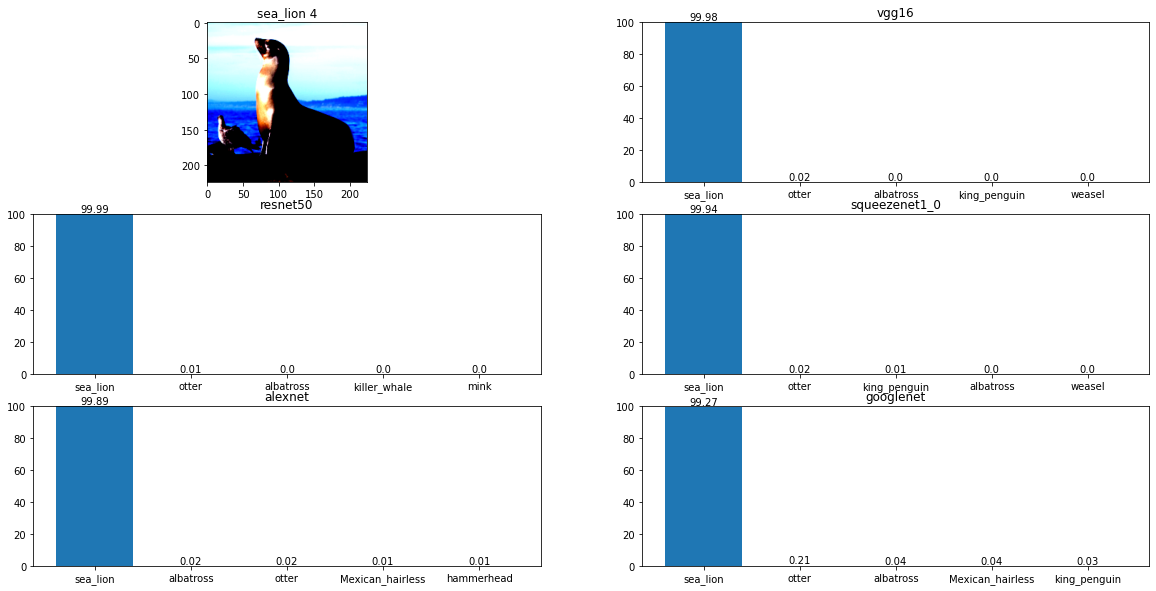

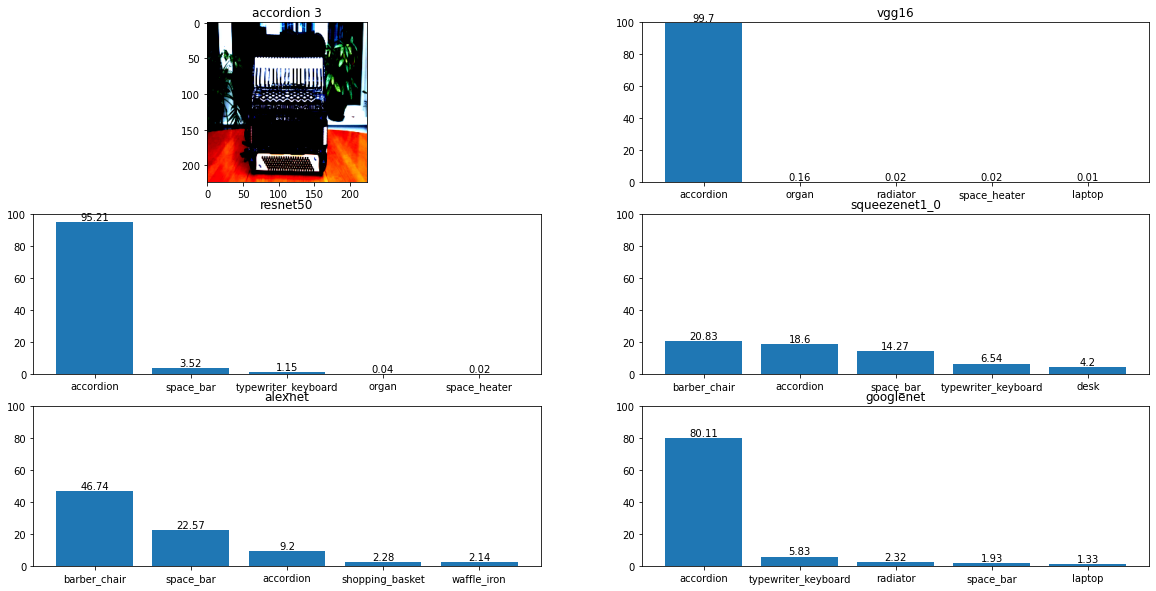

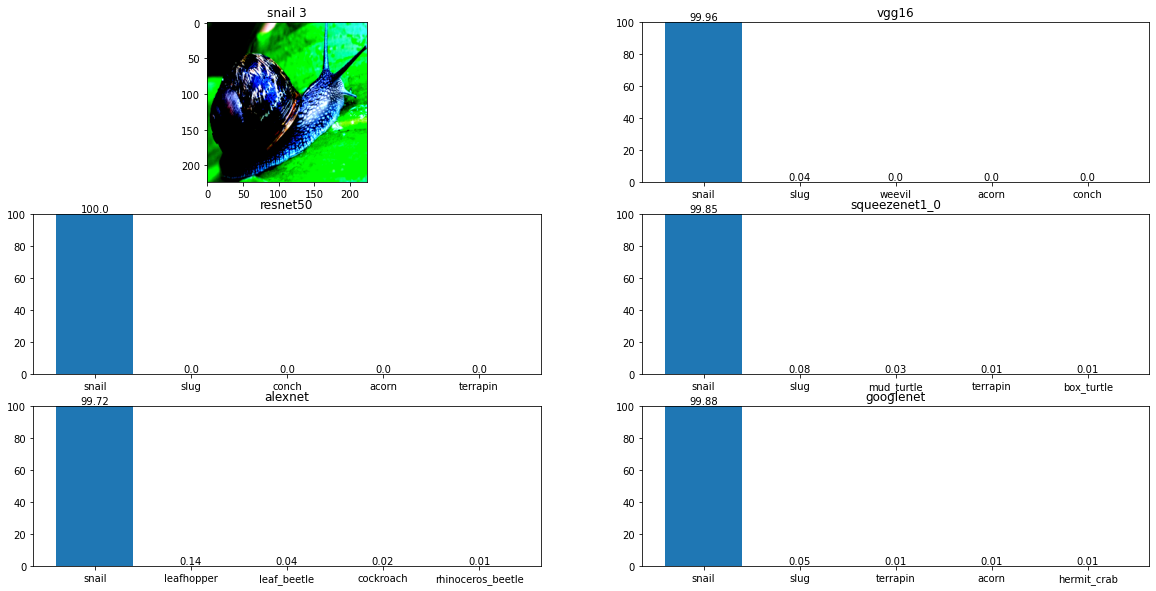

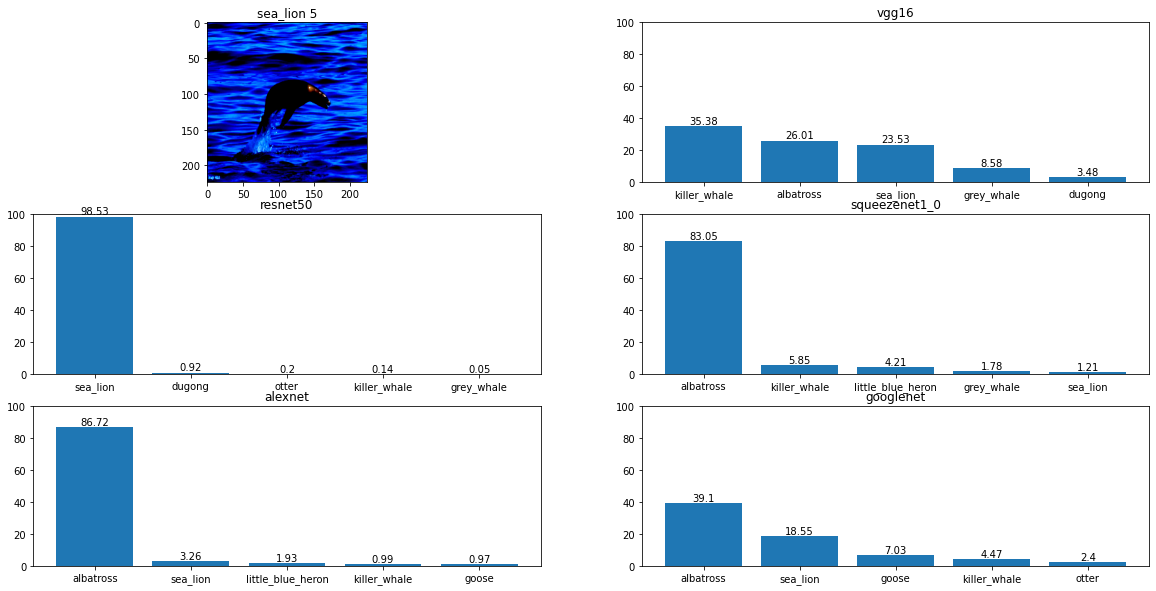

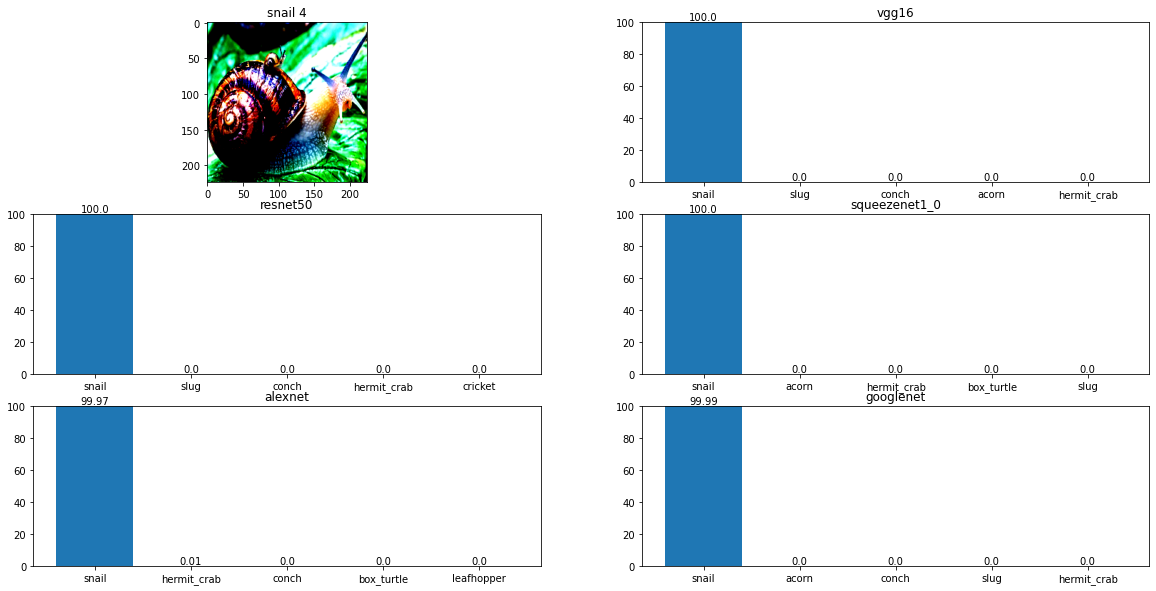

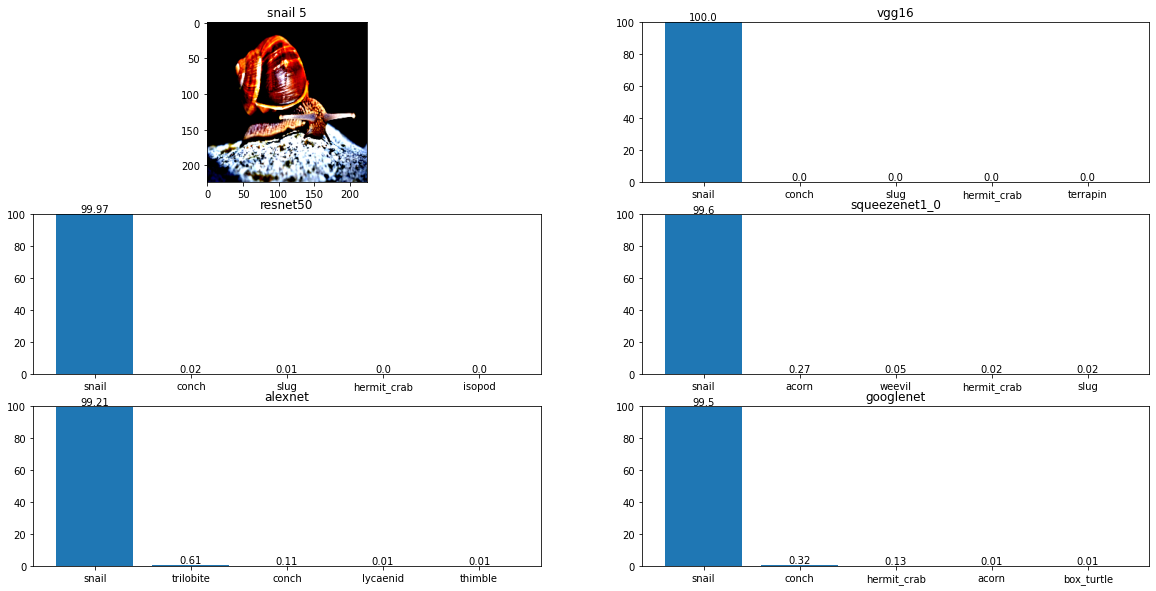

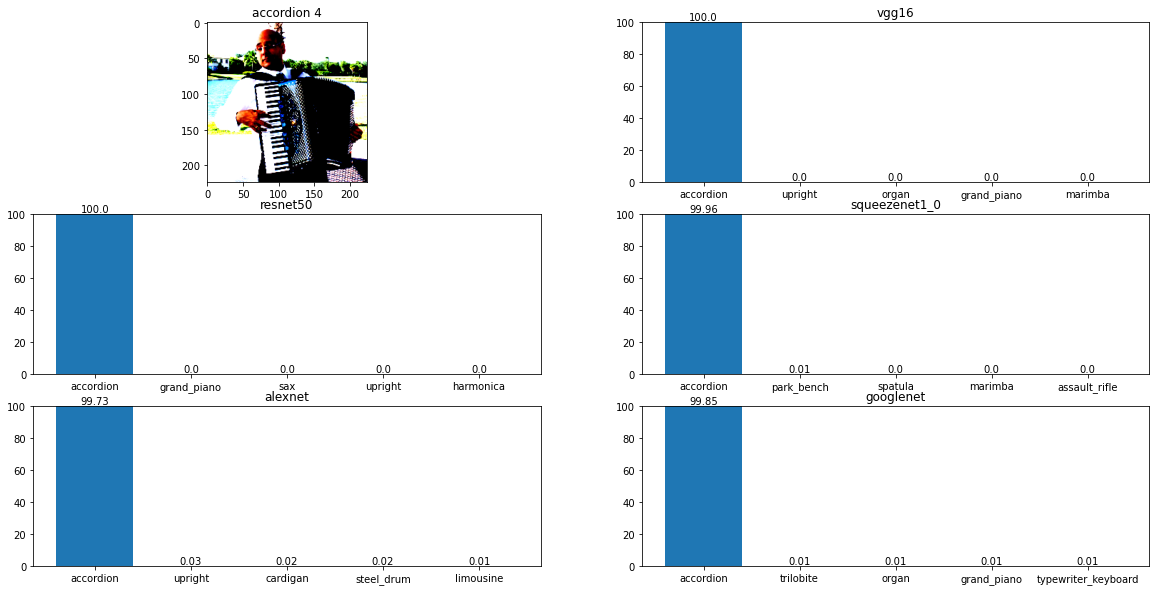

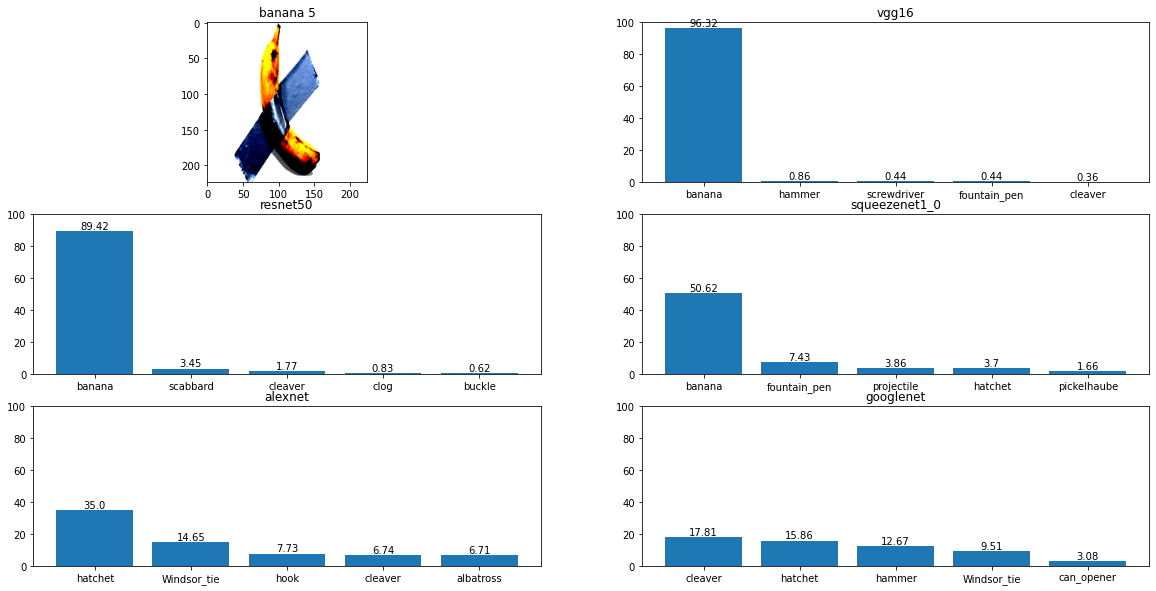

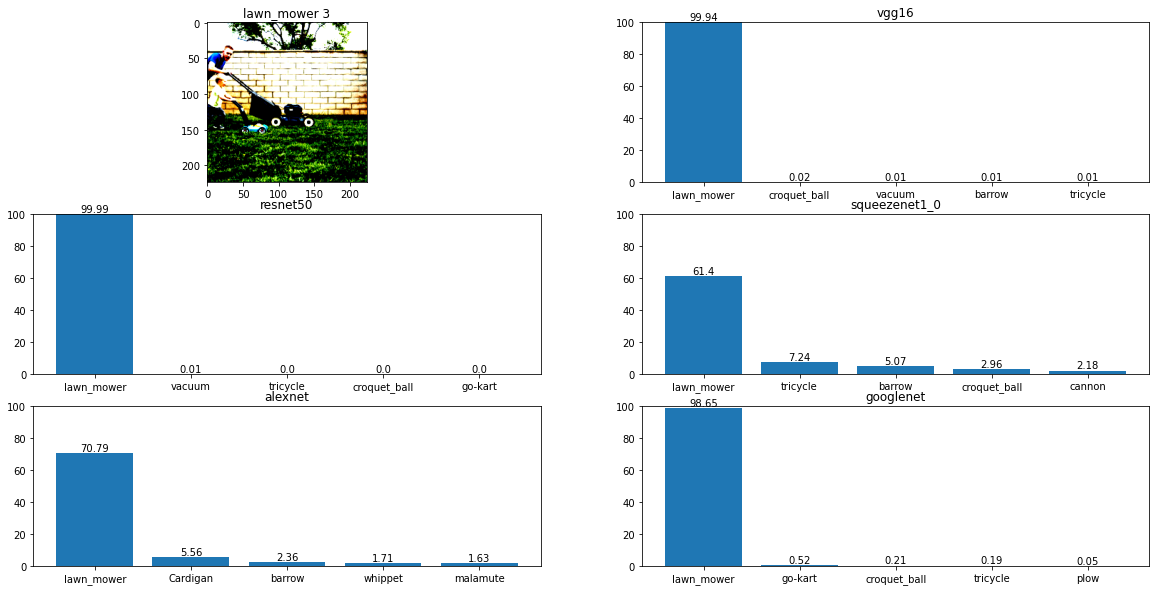

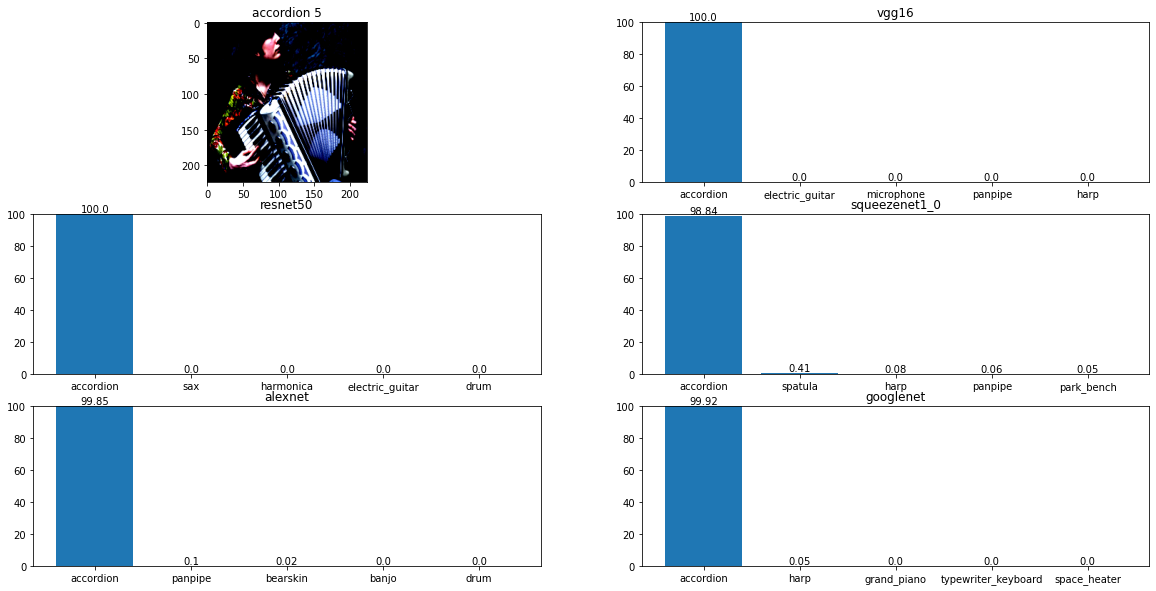

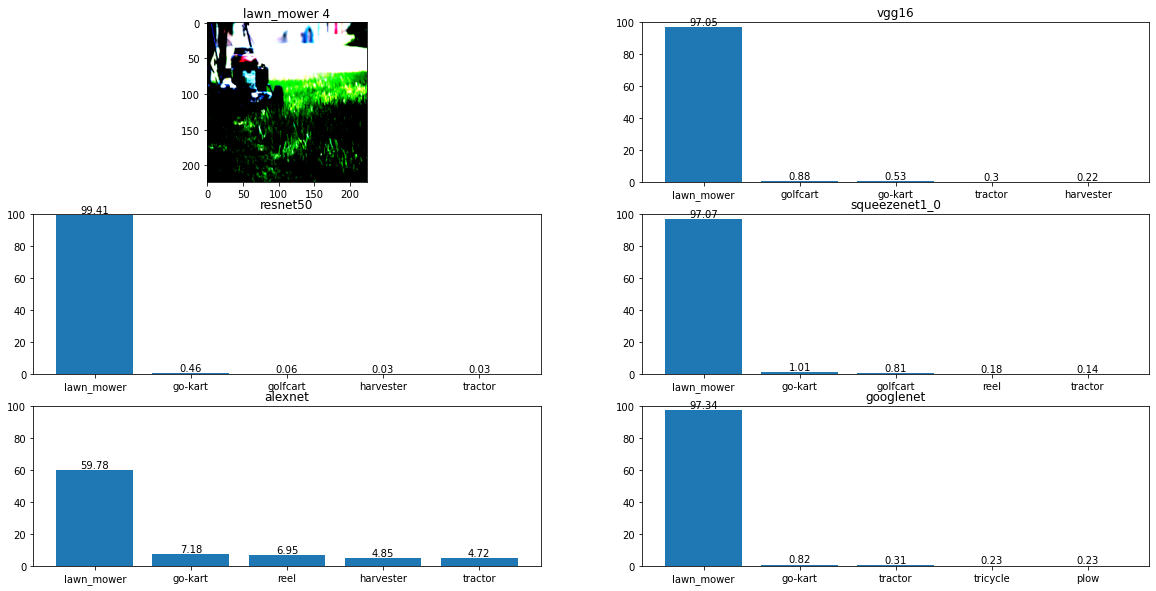

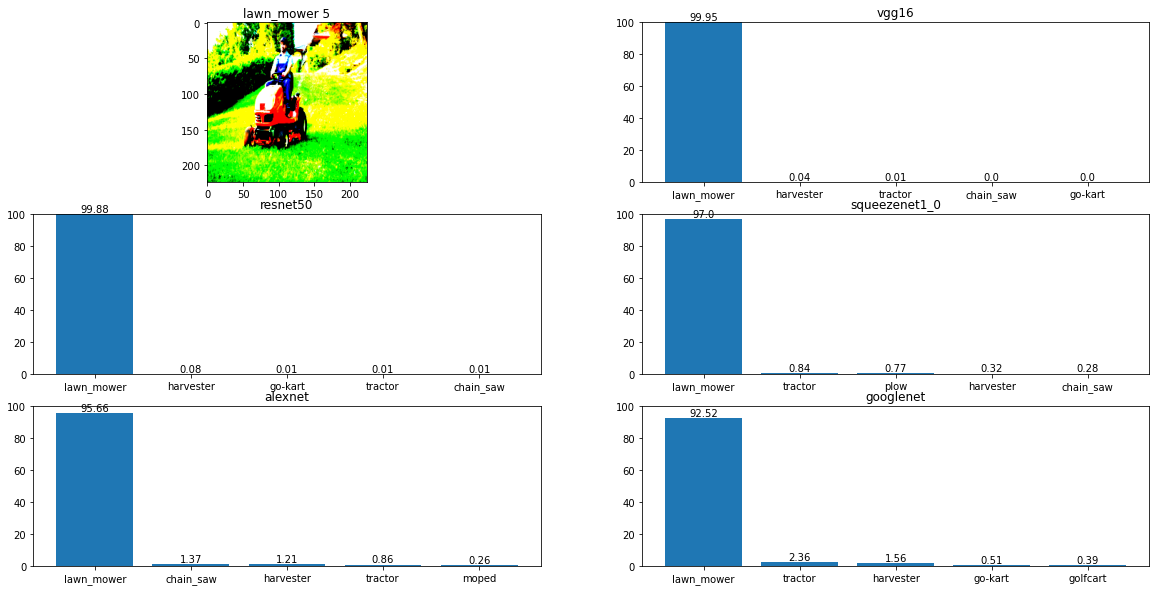

In [61]:
my_image_counts = {
    0 : 0,
    1 : 0,
    2 : 0,
    3 : 0,
    4 : 0
}

correct_pred_per_model = {
    "resnet50" : copy.copy(image_counts),
    "alexnet" : copy.copy(image_counts),
    "vgg16" : copy.copy(image_counts),
    "squeezenet1_0" : copy.copy(image_counts),
    "googlenet" : copy.copy(image_counts) 
}

image = 0        
for inputs, label in dataloader:

    my_image_counts[int(label)] += 1
    
    label_names = []
    my_probs = []
    for name,model in model_names.items():
        model.eval()
        with torch.no_grad():
            logps = model.forward(inputs)
            ps = torch.nn.functional.softmax(logps[0], dim=0)

            probs = torch.topk(ps, 5).values.numpy()*100
            my_probs.append(np.around(probs, decimals=2))
            pred_labels = torch.topk(ps, 5).indices.numpy()
            label_names.append([imagenet_labels_names[x] for x in pred_labels])
            try:
                if my_labels_dict[int(torch.topk(ps, 1).indices[0])]==int(label):
                    correct_pred_per_model[name][int(label)] += 1
            except:
                pass


    fig, ax = plt.subplots(3,2,figsize=(20,10))
    
    ax[0][0].imshow(inputs[0].permute(1, 2, 0))
    ax[0][0].set_title(label_name[label.item()] + " " + str(my_image_counts[int(label)]))
    label
    for j in range(2):
        for i in range(3):
#             print(i+3*j)
            if(i+3*j==0 or i+3*j==6):
                continue
            ax[i][j].set_title(list(model_names.keys())[i+3*j - 1])
            cont = ax[i][j].bar([0,1,2,3,4], my_probs[i+3*j - 1], align='center')
            ax[i][j].set_xticks([0,1,2,3,4])
            ax[i][j].set_ylim([0, 100])
            ax[i][j].set_xticklabels(label_names[i+3*j - 1])
            ax[i][j].bar_label(cont,my_probs[i+3*j - 1])
            
            plt.savefig("./part_A/results/" + label_name[int(label)] + "_" + str(my_image_counts[int(label)]) +".png")
        if(i+3*j==0 or i+3*j==6):
            continue
    
            


In [62]:
for model_name,acc in correct_pred_per_model.items():
    print("Accuracy of " + model_name + " is : ",100*sum(acc.values())/total,"%")

Accuracy of resnet50 is :  96.0 %
Accuracy of alexnet is :  80.0 %
Accuracy of vgg16 is :  88.0 %
Accuracy of squeezenet1_0 is :  80.0 %
Accuracy of googlenet is :  80.0 %


# Part B

## Useful functions for training and testing

In [2]:
# training function
def train_val(model, epochs = 15):
    
    steps = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []


    train_loss = 0
    train_accuracy = 0

    for epoch in range(epochs):
        kbar = pkbar.Kbar(target=len(train_loader), epoch=epoch, num_epochs=epochs, width=8, always_stateful=False)
        batch_num = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            logps = model.forward(inputs)
            loss = criterion(logps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()


            # accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            kbar.update(batch_num, values=[("Loss", loss), ("Train accuracy", torch.mean(equals.type(torch.FloatTensor)).item())])

            batch_num += 1

        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)

                val_loss += batch_loss.item()

                # Calculate accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()


        kbar.add(1, values=[("Val loss", val_loss/len(val_loader)), ("Val accuracy", val_accuracy/len(val_loader))])
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {train_loss/len(train_loader):.3f}.. "
              f"Val loss: {val_loss/len(val_loader):.3f}.. "
              f"Train accuracy: {train_accuracy/len(train_loader):.3f}.."
              f"Val accuracy: {val_accuracy/len(val_loader):.3f}")

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        train_accuracies.append(train_accuracy/len(train_loader))
        val_accuracies.append(val_accuracy/len(val_loader))

        train_loss = 0
        train_accuracy = 0
        model.train()





    plt.figure(figsize=(14,7))
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend(frameon=False)

    plt.figure(figsize=(14,7))
    plt.plot(train_accuracies, label='Training accuracy')
    plt.plot(val_accuracies, label='Validation accuracy')
    plt.legend(frameon=False)
    
    return

In [4]:
# test and results function
def test_results(model):
    tot_test_loss = 0
    test_correct = 0  
    all_predictions = []
    all_labels = []


    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            log_ps = model(inputs)
            loss = criterion(log_ps, labels)
            tot_test_loss += loss.item()

            ps = torch.exp(log_ps).cpu()
            top_p, top_class = ps.topk(1, dim=1)
            top_p, top_class =top_p.cpu(), top_class.cpu()
            all_predictions.append(list(top_class.numpy().squeeze()))
            all_labels.append(list(labels.cpu().cpu().numpy().squeeze()))
            equals = top_class == labels.cpu().view(*top_class.shape)
            test_correct += equals.sum().item()

            test_loss = tot_test_loss / len(test_loader.dataset)

    print("Test Loss: {:.3f}.. ".format(test_loss),"Test Accuracy: {:.3f}".format(test_correct / len(test_loader.dataset)))

    pred_list = [item for sublist in all_predictions for item in sublist]
    labels_list = [item for sublist in all_labels for item in sublist]

    prec, rec, f1, sup = precision_recall_fscore_support(labels_list, pred_list)

    print("Precision :", prec)
    print("Recall :", rec)
    print("F1 Score :", f1)



    prec_weighted, rec_weighted, f1_weighted, sup_weighted = precision_recall_fscore_support(labels_list, pred_list,average='weighted')

    print("Precision weighted:", prec_weighted)
    print("Recall weighted:", rec_weighted)
    print("F1 Score weighted:", f1_weighted)

    cm=confusion_matrix(labels_list,pred_list)

    df_cm = pd.DataFrame(cm, index = range(1,11),
                      columns = range(1,11))
    plt.figure(figsize = (10,8)) 
    sn.heatmap(df_cm, annot=True,fmt='d',yticklabels=label_names,xticklabels=label_names)
    t = plt.yticks(rotation=0)
    t = plt.xticks(rotation=45)

    return

## Data Custom Import

In [3]:
with open('./part_B/train_split.json') as json_file:
    train_data = json.load(json_file)
with open('./part_B/val_split.json') as json_file:
    val_data = json.load(json_file)
with open('./part_B/test_split.json') as json_file:
    test_data = json.load(json_file)
    
label_names_encodings_dict = {
    0: 'AnnualCrop',
    1: 'Forest',
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}
label_names = list(label_names_encodings_dict.values())

In [4]:
class my_Dataset(Dataset):
    """
    The Class will act as the container for our dataset. It will take your dataframe, the root path, and also the transform function for transforming the dataset.
    """
    def __init__(self, data_list, root_dir, transform=None):
        
        labels = [x.split("/")[1] for x in data_list ]
        df = pd.DataFrame(list(zip(data_list, labels)),columns =['path', 'label'])
        
        le = LabelEncoder()
        df['label_encoded'] = le.fit_transform(df['label'])
        
        self.data_frame = df
        self.root_dir = root_dir
        self.transform = transform
            
    def __len__(self):
        # Return the length of the dataset
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Return the observation based on an index. Ex. dataset[0] will return the first element from the dataset, in this case the image and the label.
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.data_frame.iloc[idx, -1]

        if self.transform:
            image = self.transform(image)

        return (image, label)

In [5]:
transform=transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225])
])

In [6]:
batch_size = 128
train_dataset = my_Dataset(train_data,"./part_B/EuroSAT/",transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

In [7]:
for inputs, labels in train_loader:
    print(inputs.type())
    break

torch.FloatTensor


In [5]:
batch_size = 128
train_dataset = my_Dataset(train_data,"./part_B/EuroSAT/",transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)

val_dataset = my_Dataset(val_data,"./part_B/EuroSAT/",transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = my_Dataset(test_data,"./part_B/EuroSAT/",transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

NameError: name 'transform' is not defined

## 1) Pretrained Model

In [18]:
transfer_model = models.resnet50(pretrained=True)

for param in transfer_model.parameters():
    param.requires_grad = False



## for alexnet
# classifier = nn.Sequential(OrderedDict([
#                           ('fc1', nn.Linear(9216, 50)),
#                           ('relu', nn.ReLU()),
#                           ('fc2', nn.Linear(50, 10)),
#                           ('output', nn.LogSoftmax(dim=1))
#                           ]))
# transfer_model.classifier = classifier
# optimizer = optim.Adam(transfer_model.classifier.parameters(), lr=0.001)


## for resnet
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 50)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(50, 10)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
transfer_model.fc = classifier
optimizer = optim.Adam(transfer_model.fc.parameters(), lr=0.001)

criterion = nn.NLLLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


transfer_model.to(device)


cuda


In [ ]:
summary(transfer_model,(128,3,224,224))

Epoch: 1/15
148/148 [========] - 96s 651ms/step - Loss: 0.8808 - Train accuracy: 0.7350 - Val loss: 0.5252 - Val accuracy: 0.8349
Epoch 1/15.. Train loss: 0.891.. Val loss: 0.525.. Train accuracy: 0.731..Val accuracy: 0.835
Epoch: 2/15
148/148 [========] - 92s 619ms/step - Loss: 0.5160 - Train accuracy: 0.8269 - Val loss: 0.4860 - Val accuracy: 0.8292
Epoch 2/15.. Train loss: 0.517.. Val loss: 0.486.. Train accuracy: 0.827..Val accuracy: 0.829
Epoch: 3/15
148/148 [========] - 92s 620ms/step - Loss: 0.4529 - Train accuracy: 0.8461 - Val loss: 0.4269 - Val accuracy: 0.8558
Epoch 3/15.. Train loss: 0.454.. Val loss: 0.427.. Train accuracy: 0.846..Val accuracy: 0.856
Epoch: 4/15
148/148 [========] - 100s 677ms/step - Loss: 0.4369 - Train accuracy: 0.8549 - Val loss: 0.3927 - Val accuracy: 0.8688
Epoch 4/15.. Train loss: 0.437.. Val loss: 0.393.. Train accuracy: 0.855..Val accuracy: 0.869
Epoch: 5/15
148/148 [========] - 99s 668ms/step - Loss: 0.4169 - Train accuracy: 0.8577 - Val loss: 0.3

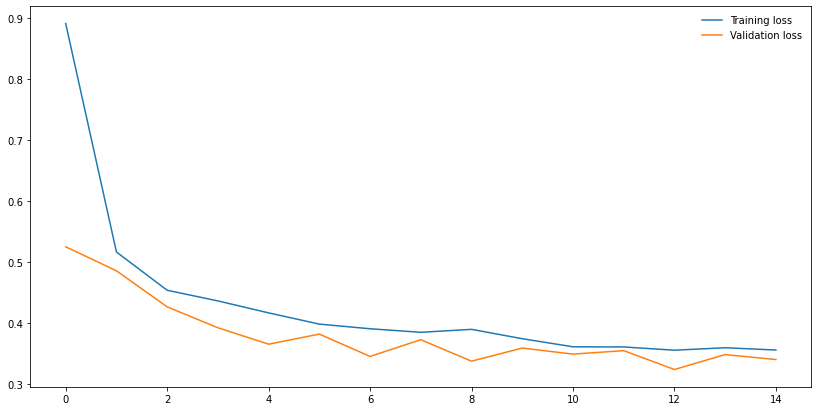

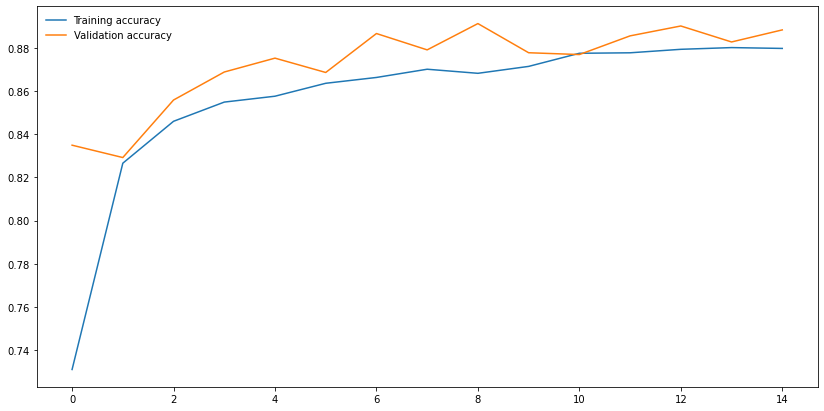

In [19]:
train_val(transfer_model)

In [16]:
test_results(transfer_model)

NameError: name 'transfer_model' is not defined

## 2) Custom Model

In [50]:
class my_net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        
        self.max1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.max2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.max3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.max4 = nn.MaxPool2d(kernel_size=2, stride=2)
        

        self.dropout = nn.Dropout(0.2)
           
        self.fc1 = nn.Linear(9216, 100)
        self.fc2 = nn.Linear(100, 10)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
    
    def forward(self, x):
        
        # encoder
        x = self.bn1(F.relu(self.max1(self.conv1(x))))
        x = self.bn2(F.relu(self.max2(self.conv2(x))))
        x = self.bn3(F.relu(self.max3(self.conv3(x))))
        x = self.bn4(F.relu(self.max4(self.conv4(x))))
        
        # classifier        
        x = x.view(-1, 256 * 6 * 6)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x
    
    
t = my_net()
summary(t,(128,3,224,224))

torch.Size([128, 256, 6, 6])


Layer (type:depth-idx)                   Output Shape              Param #
my_net                                   --                        --
├─Conv2d: 1-1                            [128, 32, 111, 111]       2,432
├─MaxPool2d: 1-2                         [128, 32, 55, 55]         --
├─BatchNorm2d: 1-3                       [128, 32, 55, 55]         64
├─Conv2d: 1-4                            [128, 64, 53, 53]         51,264
├─MaxPool2d: 1-5                         [128, 64, 26, 26]         --
├─BatchNorm2d: 1-6                       [128, 64, 26, 26]         128
├─Conv2d: 1-7                            [128, 128, 26, 26]        73,856
├─MaxPool2d: 1-8                         [128, 128, 13, 13]        --
├─BatchNorm2d: 1-9                       [128, 128, 13, 13]        256
├─Conv2d: 1-10                           [128, 256, 13, 13]        295,168
├─MaxPool2d: 1-11                        [128, 256, 6, 6]          --
├─BatchNorm2d: 1-12                      [128, 256, 6, 6]          

cuda
Epoch: 1/30
148/148 [========] - 41s 276ms/step - Loss: 1.2368 - Train accuracy: 0.5867 - Val loss: 0.9081 - Val accuracy: 0.7084
Epoch 1/30.. Train loss: 1.245.. Val loss: 0.908.. Train accuracy: 0.583..Val accuracy: 0.708
Epoch: 2/30
148/148 [========] - 41s 275ms/step - Loss: 0.9166 - Train accuracy: 0.6840 - Val loss: 1.0671 - Val accuracy: 0.6440
Epoch 2/30.. Train loss: 0.916.. Val loss: 1.067.. Train accuracy: 0.684..Val accuracy: 0.644
Epoch: 3/30
148/148 [========] - 41s 277ms/step - Loss: 0.7746 - Train accuracy: 0.7332 - Val loss: 0.6544 - Val accuracy: 0.7797
Epoch 3/30.. Train loss: 0.776.. Val loss: 0.654.. Train accuracy: 0.733..Val accuracy: 0.780
Epoch: 4/30
148/148 [========] - 41s 280ms/step - Loss: 0.6779 - Train accuracy: 0.7661 - Val loss: 0.6476 - Val accuracy: 0.7675
Epoch 4/30.. Train loss: 0.678.. Val loss: 0.648.. Train accuracy: 0.766..Val accuracy: 0.768
Epoch: 5/30
148/148 [========] - 44s 300ms/step - Loss: 0.6361 - Train accuracy: 0.7830 - Val loss:

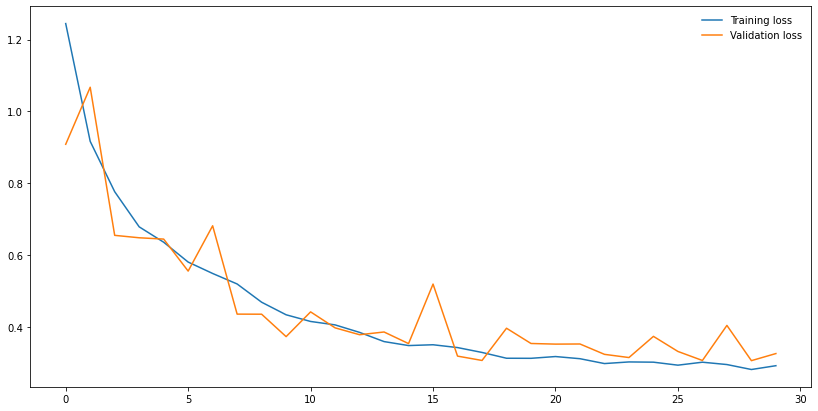

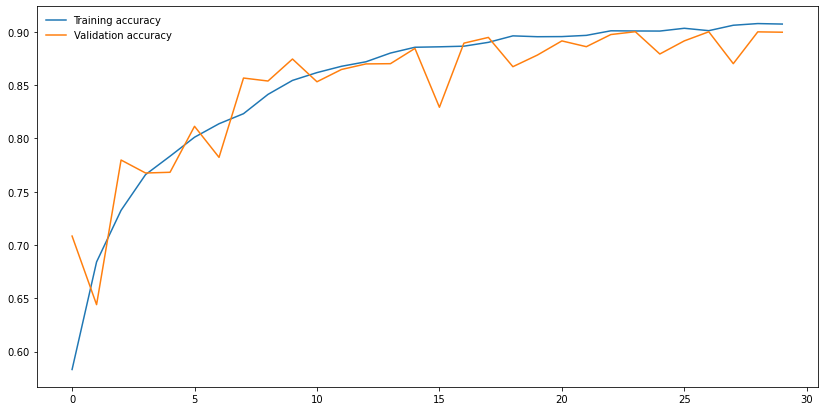

In [25]:
my_model = my_net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
criterion = nn.NLLLoss()

optimizer = optim.Adam(my_model.parameters(), lr=0.001,weight_decay=0.001)

my_model.to(device);


epochs = 30
train_val(my_model, epochs)

Test Loss: 0.003..  Test Accuracy: 0.897
Precision : [0.85200846 0.97482838 0.93333333 0.94017094 0.9641791  0.81028939
 0.79405034 0.90778689 0.89306358 0.90160183]
Recall : [0.89159292 0.92207792 0.84759916 0.87301587 0.88010899 0.88732394
 0.88974359 0.97149123 0.824      0.96805897]
F1 Score : [0.87135135 0.94771969 0.88840263 0.90534979 0.92022792 0.84705882
 0.83917775 0.93855932 0.85714286 0.93364929]
Precision weighted: 0.900589376353624
Recall weighted: 0.8970370370370371
F1 Score weighted: 0.8973923321745912


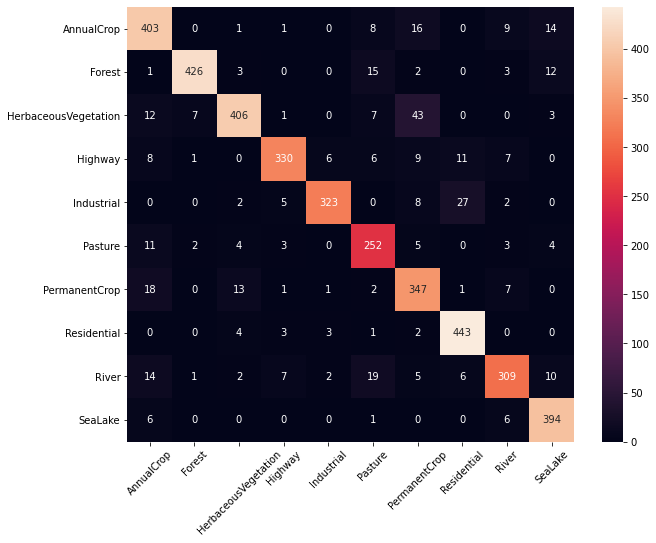

In [26]:
test_results(my_model)

## 3) Skip Connections Model

In [10]:
class skip_connections_net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1_1 = nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=2)
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2)
        self.conv1_3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        
        
        self.conv2_1 = nn.Conv2d(16, 32, kernel_size=7, stride=2, padding=2)
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2)
        self.conv2_3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        
        self.conv3_1 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
    
        self.conv4_1 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.conv4_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        

        self.conv5_1 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.conv5_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        
        self.conv6_1 = nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2)
        self.conv6_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv6_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        
        
        self.dropout = nn.Dropout(0.2)
           
        self.fc1 = nn.Linear(512 * 4 * 4, 50)
        self.fc2 = nn.Linear(50, 10)
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)
        self.bn6 = nn.BatchNorm2d(512)
    
        self.max = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        
        # encoder
        x = F.relu(self.conv1_1(x))
        res1 = x
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv1_3(x))
        x += res1
        x = self.bn1(x)
        
        
        x = F.relu(self.conv2_1(x))
        res2 = x
        x = F.relu(self.conv2_2(x))
        x = F.relu(self.conv2_3(x))
        x += res2
        x = self.bn2(x)
        
        
        x = F.relu(self.conv3_1(x))
        res3 = x
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x += res3
        x = self.bn3(x)
        
        
        x = F.relu(self.conv4_1(x))
        res4 = x
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x += res4
        x = self.bn4(x)
        
        
        x = F.relu(self.conv5_1(x))
        res5 = x
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x += res5
        x = self.bn5(x)
        
        x = F.relu(self.conv6_1(x))
        res6 = x
        x = F.relu(self.conv6_2(x))
        x = F.relu(self.conv6_3(x))
        x += res6
        x = self.bn6(x)
        
        # classifier
        x = x.view(-1, 512 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x
    
    
    
model = skip_connections_net()
summary(model,(128,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
skip_connections_net                     --                        --
├─Conv2d: 1-1                            [128, 16, 111, 111]       2,368
├─Conv2d: 1-2                            [128, 16, 111, 111]       6,416
├─Conv2d: 1-3                            [128, 16, 111, 111]       2,320
├─BatchNorm2d: 1-4                       [128, 16, 111, 111]       32
├─Conv2d: 1-5                            [128, 32, 55, 55]         25,120
├─Conv2d: 1-6                            [128, 32, 55, 55]         25,632
├─Conv2d: 1-7                            [128, 32, 55, 55]         9,248
├─BatchNorm2d: 1-8                       [128, 32, 55, 55]         64
├─Conv2d: 1-9                            [128, 64, 28, 28]         51,264
├─Conv2d: 1-10                           [128, 64, 28, 28]         36,928
├─Conv2d: 1-11                           [128, 64, 28, 28]         36,928
├─BatchNorm2d: 1-12                      [128, 64, 28

cuda
Epoch: 1/30
148/148 [========] - 71s 482ms/step - Loss: 1.6288 - Train accuracy: 0.4162 - Val loss: 1.5450 - Val accuracy: 0.4586
Epoch 1/30.. Train loss: 1.634.. Val loss: 1.545.. Train accuracy: 0.414..Val accuracy: 0.459
Epoch: 2/30
148/148 [========] - 70s 474ms/step - Loss: 1.2471 - Train accuracy: 0.5703 - Val loss: 1.0394 - Val accuracy: 0.6365
Epoch 2/30.. Train loss: 1.249.. Val loss: 1.039.. Train accuracy: 0.570..Val accuracy: 0.637
Epoch: 3/30
148/148 [========] - 72s 488ms/step - Loss: 1.0515 - Train accuracy: 0.6335 - Val loss: 1.1845 - Val accuracy: 0.6022
Epoch 3/30.. Train loss: 1.051.. Val loss: 1.184.. Train accuracy: 0.634..Val accuracy: 0.602
Epoch: 4/30
148/148 [========] - 71s 483ms/step - Loss: 0.9607 - Train accuracy: 0.6677 - Val loss: 0.9891 - Val accuracy: 0.6358
Epoch 4/30.. Train loss: 0.961.. Val loss: 0.989.. Train accuracy: 0.668..Val accuracy: 0.636
Epoch: 5/30
148/148 [========] - 71s 479ms/step - Loss: 0.8780 - Train accuracy: 0.6980 - Val loss:

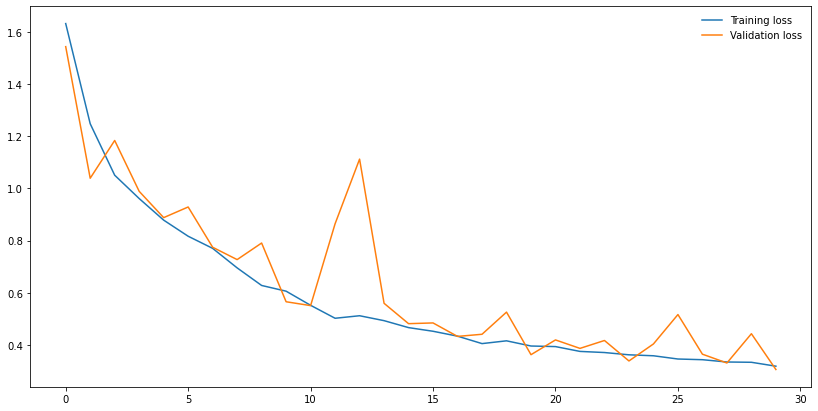

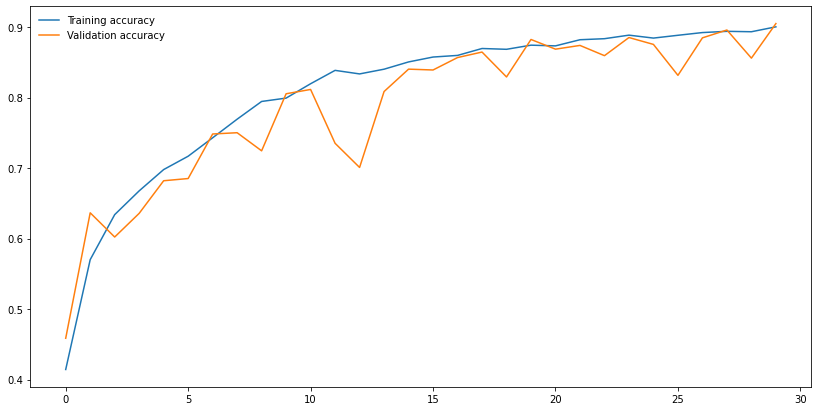

In [11]:
my_model = skip_connections_net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device="cpu"
print(device)
criterion = nn.NLLLoss()

optimizer = optim.Adam(my_model.parameters(), lr=0.001,weight_decay=0.001)

my_model.to(device);


epochs = 30
train_val(my_model, epochs)

Test Loss: 0.002..  Test Accuracy: 0.902
Precision : [0.89655172 0.95338983 0.81535649 0.91340782 0.92631579 0.85616438
 0.87202381 0.9650655  0.89142857 0.92654028]
Recall : [0.86283186 0.97402597 0.93110647 0.86507937 0.95912807 0.88028169
 0.75128205 0.96929825 0.832      0.96068796]
F1 Score : [0.87936866 0.96359743 0.86939571 0.88858696 0.94243641 0.86805556
 0.80716253 0.96717724 0.86068966 0.94330519]
Precision weighted: 0.9027621581511482
Recall weighted: 0.9019753086419753
F1 Score weighted: 0.9012086533062947


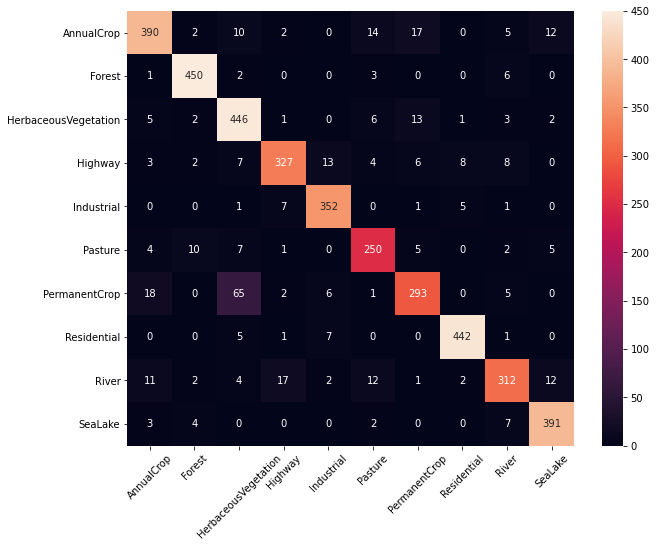

In [13]:
test_results(my_model)